In [36]:
%pip install numpy==1.26.4 tensorflow==2.10.1 tensorflow-addons==0.19.0

  Using cached tensorflow_addons-0.19.0-cp310-cp310-win_amd64.whl.metadata (1.8 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl.metadata (1.9 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl.metadata (1.9 kB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/15.8 MB 1.9 MB/s eta 0:00:09
   - -------------------------------------- 0.8/15.8 MB 1.7 MB/s eta 0:00:09
   -- ------------------------------------- 1.0/15.8 MB 1.8 MB/s eta 0:00:09
   -- ------------------------------------- 1.0/15.8 MB 1.8 MB/s eta 0:00:09
   --- ------------------------------------ 1.3/15.8 MB 1.3 MB/s eta 0:00:12
   --- ------------------------------------ 1.6/15.8 MB 1.2 MB/s eta 0:00:13
   ----- ---------------------------------- 2.1/15.8 MB 1.4 MB/s eta 0:00:10
   ------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorboard<2.12,>=2.11, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-intel 2.11.0 requires tensorflow-estimator<2.12,>=2.11.0, but you have tensorflow-estimator 2.10.0 which is incompatible.


   -------------------------------- ------- 364.9/455.9 MB 1.8 MB/s eta 0:00:51
   -------------------------------- ------- 365.4/455.9 MB 1.8 MB/s eta 0:00:51
   -------------------------------- ------- 365.7/455.9 MB 1.8 MB/s eta 0:00:51
   -------------------------------- ------- 366.2/455.9 MB 1.8 MB/s eta 0:00:50
   -------------------------------- ------- 366.5/455.9 MB 1.8 MB/s eta 0:00:50
   -------------------------------- ------- 367.0/455.9 MB 1.8 MB/s eta 0:00:50
   -------------------------------- ------- 367.3/455.9 MB 1.8 MB/s eta 0:00:50
   -------------------------------- ------- 367.3/455.9 MB 1.8 MB/s eta 0:00:50
   -------------------------------- ------- 367.3/455.9 MB 1.8 MB/s eta 0:00:50
   -------------------------------- ------- 368.1/455.9 MB 1.8 MB/s eta 0:00:50
   -------------------------------- ------- 368.3/455.9 MB 1.8 MB/s eta 0:00:50
   -------------------------------- ------- 368.6/455.9 MB 1.8 MB/s eta 0:00:50
   -------------------------------- ----

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import tensorflow as tf
import keras
import os
import cv2

In [76]:
def get_df(original_images_dir, masked_images_dir):
    class_names = os.listdir(original_images_dir)

    original_file_path = []
    masked_file_path = []
    classes = []
    for class_name in class_names:
        for file_name in os.listdir(os.path.join(original_images_dir, class_name)):
            masked_file_path.append(os.path.join(masked_images_dir, class_name, file_name))
            original_file_path.append(os.path.join(original_images_dir, class_name, file_name))
            classes.append(class_name)

    df = pd.DataFrame({
        "OriginalPath": original_file_path,
        "MaskedPath": masked_file_path,
        "Class": classes
    })

    return df

In [77]:
train_df = get_df("./original/original/Training", "./swinunet/swinunet/Training")
test_df = get_df("./original/original/Testing", "./swinunet/swinunet/Testing")

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import pickle

In [79]:
valid_df, test_df = train_test_split(test_df, test_size = 0.5, random_state = 42, stratify = test_df["Class"], shuffle = True)

In [80]:
class_names = sorted(train_df['Class'].unique())
class_to_index = {name: i for i, name in enumerate(class_names)}

def load_and_combine(image_path, mask_path):
    # Load and decode image and mask
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # Use channels=1 for grayscale
    image = tf.image.convert_image_dtype(image, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)

    # Resize if needed (optional)
    image = tf.image.resize(image, [224, 224])
    mask = tf.image.resize(mask, [224, 224])

    # Concatenate along the channel axis
    combined = tf.concat([image, mask], axis = -1)  # Shape: (H, W, 2)

    return combined

def preprocess(image_path, mask_path, label):
    combined = load_and_combine(image_path, mask_path)
    label_one_hot = tf.one_hot(label, depth=4)
    return combined, label_one_hot

def create_dataset(df, class_to_index, batch_size=32, shuffle=True):
    image_paths = df["OriginalPath"].values
    mask_paths = df["MaskedPath"].values
    labels = df["Class"].map(class_to_index).values

    ds = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths, labels))
    ds = ds.map(lambda x, y, z: preprocess(x, y, z), num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [81]:
train_ds = create_dataset(train_df, class_to_index)
valid_ds = create_dataset(valid_df, class_to_index, shuffle = False)
test_ds = create_dataset(test_df, class_to_index, shuffle = False)

In [82]:
y_true = test_df["Class"].map(class_to_index)

In [83]:
y_true_one_hot = keras.utils.to_categorical(y_true, num_classes = 4)

In [84]:
def get_feature_extractor():
    cnn = keras.models.Sequential()    

    # Convulational Layer 1
    cnn.add(keras.layers.Conv2D(
        filters = 32, 
        kernel_size = 3, 
        input_shape = [224, 224, 2], 
        kernel_regularizer = keras.regularizers.l2(0.00005),
        padding = "same"
    ))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.ReLU())

    # Pooling Layer 1
    cnn.add(keras.layers.MaxPool2D(
        pool_size = 2, 
        strides = 2
    ))

    # Convulational Layer 2
    cnn.add(keras.layers.Conv2D(
        filters = 64, 
        kernel_size = 3, 
        kernel_regularizer = keras.regularizers.l2(0.00005),
        padding = "same"
    ))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.ReLU())

    # Pooling Layer 2
    cnn.add(keras.layers.MaxPool2D(
        pool_size = 2, 
        strides = 2
    ))

    # Convulational Layer 3
    cnn.add(keras.layers.Conv2D(
        filters = 128, 
        kernel_size = 3, 
        kernel_regularizer = keras.regularizers.l2(0.00005),
        padding = "same"
    ))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.ReLU())

    # Pooling Layer 3
    cnn.add(keras.layers.MaxPool2D(
        pool_size = 2, 
        strides = 2
    ))

    # Convulational Layer 4
    cnn.add(keras.layers.Conv2D(
        filters = 128, 
        kernel_size = 3, 
        kernel_regularizer = keras.regularizers.l2(0.00005),
        padding = "same"
    ))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.ReLU())

    # Pooling Layer 4
    cnn.add(keras.layers.MaxPool2D(
        pool_size = 2, 
        strides = 2
    ))  
 
    # Flatten Layer 
    cnn.add(keras.layers.Flatten())  

    return cnn  

In [69]:
cnn = get_feature_extractor()

# Fully Connected Layer 1
cnn.add(keras.layers.Dense(
    units = 128,
    kernel_regularizer = keras.regularizers.l2(0.00005)
))
cnn.add(keras.layers.BatchNormalization())
cnn.add(keras.layers.ReLU())


# Droput Layer
cnn.add(keras.layers.Dropout(0.4))

# Output Layer
cnn.add(keras.layers.Dense(
    units = 4, 
    activation = "softmax"
))

In [71]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = "val_loss", 
    patience = 10, 
    restore_best_weights = True
)

In [72]:
cnn.compile(
    optimizer = keras.optimizers.Adam(
        learning_rate = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 1e-4,
            decay_steps = 1000,
            decay_rate = 0.95
        )
    ), 
    loss = "categorical_crossentropy", 
    metrics = [keras.metrics.Recall()]
)

In [85]:
history = cnn.fit(
    train_ds, 
    validation_data = valid_ds, 
    epochs = 100, 
    callbacks = [early_stopping]
)

Epoch 1/100


179/179 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - loss: 0.0734 - recall: 0.9909 - val_loss: 0.2335 - val_recall: 0.9298
Epoch 2/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - loss: 0.0588 - recall: 0.9946 - val_loss: 0.1340 - val_recall: 0.9618
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - loss: 0.0552 - recall: 0.9961 - val_loss: 0.1143 - val_recall: 0.9679
Epoch 4/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - loss: 0.0475 - recall: 0.9994 - val_loss: 0.1149 - val_recall: 0.9740
Epoch 5/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - loss: 0.0477 - recall: 0.9979 - val_loss: 0.1723 - val_recall: 0.9542
Epoch 6/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - loss: 0.0488 - recall: 0.9971 - val_loss: 0.1214 - val_recall: 0.9649
Epoch 7/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - loss: 0.0399 - recall: 0.9997 - val_loss: 0.0990 - val_recall: 0.9756
Epoch 8/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - loss: 0.0359 - recall: 0.9995 - val_loss: 0.1438 - val_recall: 0.9603
Epoc

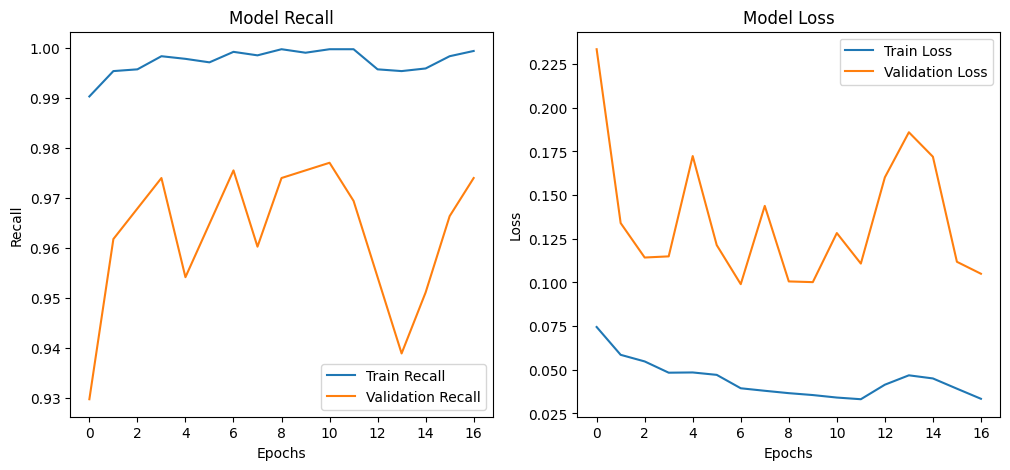

In [86]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

axes[0].plot(history.history["recall"], label = "Train Recall")
axes[0].plot(history.history["val_recall"], label = "Validation Recall")
axes[0].set_title("Model Recall")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Recall")
axes[0].legend()

axes[1].plot(history.history["loss"], label = "Train Loss")
axes[1].plot(history.history["val_loss"], label = "Validation Loss")
axes[1].set_title("Model Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.show()

In [87]:
y_prob_cnn = cnn.predict(test_ds)
y_pred_cnn= np.argmax(y_prob_cnn, axis = 1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step


In [88]:
print(confusion_matrix(y_true, y_pred_cnn))
print(classification_report(y_true, y_pred_cnn, target_names = class_names))

[[148   2   0   0]
 [  4 147   2   0]
 [  0   0 203   0]
 [  0   0   0 150]]
              precision    recall  f1-score   support

      glioma       0.97      0.99      0.98       150
  meningioma       0.99      0.96      0.97       153
     notumor       0.99      1.00      1.00       203
   pituitary       1.00      1.00      1.00       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [ ]:
cnn.save("models/cnn-swinunet")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=./models/cnn-swinunet.

In [90]:
def extract_features(dataset, model):
    features = []
    labels = []

    for images, label in dataset:
        # Get CNN features
        f = model(images, training=False)  # shape: (batch_size, feature_dim)
        features.append(f.numpy())
        labels.append(label.numpy())

    # Combine all batches into arrays
    return np.vstack(features), np.argmax(np.concatenate(labels), axis = 1)

In [91]:
feature_extractor = get_feature_extractor()

c:\Users\Brian\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [93]:
X_train, y_train = extract_features(train_ds, feature_extractor)
X_val, y_val = extract_features(valid_ds, feature_extractor)
X_test, y_test = extract_features(test_ds, feature_extractor)

In [94]:
xgb = XGBClassifier(
    objective = 'multi:softmax',
    num_class = 4,
    eval_metric = 'mlogloss',
    use_label_encoder = False,
    early_stopping_rounds=10
)

xgb.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = True)

c:\Users\Brian\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [07:51:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.01717
[1]	validation_0-mlogloss:0.82050
[2]	validation_0-mlogloss:0.67966
[3]	validation_0-mlogloss:0.57203
[4]	validation_0-mlogloss:0.49472
[5]	validation_0-mlogloss:0.43532
[6]	validation_0-mlogloss:0.38561
[7]	validation_0-mlogloss:0.34530
[8]	validation_0-mlogloss:0.31873
[9]	validation_0-mlogloss:0.29290
[10]	validation_0-mlogloss:0.27217
[11]	validation_0-mlogloss:0.25696
[12]	validation_0-mlogloss:0.24554
[13]	validation_0-mlogloss:0.23698
[14]	validation_0-mlogloss:0.22748
[15]	validation_0-mlogloss:0.21871
[16]	validation_0-mlogloss:0.21134
[17]	validation_0-mlogloss:0.20456
[18]	validation_0-mlogloss:0.19912
[19]	validation_0-mlogloss:0.19284
[20]	validation_0-mlogloss:0.19091
[21]	validation_0-mlogloss:0.18632
[22]	validation_0-mlogloss:0.18293
[23]	validation_0-mlogloss:0.17978
[24]	validation_0-mlogloss:0.17703
[25]	validation_0-mlogloss:0.17513
[26]	validation_0-mlogloss:0.17333
[27]	validation_0-mlogloss:0.17044
[28]	validation_0-mlogloss:0.1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4, ...)

In [95]:
y_pred_xgb = xgb.predict(X_test)

In [96]:
print(confusion_matrix(y_true, y_pred_xgb))
print(classification_report(y_true, y_pred_xgb, target_names = class_names))

[[136  14   0   0]
 [  4 142   6   1]
 [  0   0 203   0]
 [  0   1   0 149]]
              precision    recall  f1-score   support

      glioma       0.97      0.91      0.94       150
  meningioma       0.90      0.93      0.92       153
     notumor       0.97      1.00      0.99       203
   pituitary       0.99      0.99      0.99       150

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.96      0.96      0.96       656



In [97]:
with open('../models/xgb-swinunet.pkl', 'wb') as f:
    pickle.dump(xgb, f)

FileNotFoundError: [Errno 2] No such file or directory: '../models/xgb-swinunet.pkl'